# Chapter 3 : Labeling

#### 3.1 Do the following using a dollar bars sample:
1. Apply a symmetric CUSUM filter (Chapter 2, Section 2.5.2.1) where the threshold is the standard deviation of daily returns (Snippet 3.1).
2. Use Snippet 3.4 on a pandas series t1, where numDays=1.
3. On those sampled features, apply the triple-barrier method, where ptSl=[1,1] and t1 is the series you created in point 1.b.
4. Apply getBins to generate the labels.

In [1]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import MlFinLab tools
from mlfinlab.util.volatility import get_daily_vol
from mlfinlab.filters.filters import cusum_filter
from mlfinlab.labeling import labeling

MLFINLAB_API_KEY is valid.


In [2]:
# Read in data
url = 'https://raw.githubusercontent.com/hudson-and-thames/example-data/main/sample_dollar_bars.csv'
data = pd.read_csv(url)
data['date_time'] = pd.to_datetime(data['date_time'])
data = data.set_index('date_time')

In [3]:
data.head()

,open,high,low,close,cum_vol,cum_dollar,cum_ticks
date_time,,,,,,,
2011-07-31 23:31:58.810,1306.00,1308.75,1301.75,1305.75,53658,70035704.75,14115
2011-08-01 02:55:17.443,1305.75,1309.50,1304.00,1306.50,53552,70006277.00,15422
2011-08-01 07:25:56.319,1306.75,1309.75,1304.75,1305.00,53543,70000901.00,14727
2011-08-01 08:33:10.903,1305.00,1305.00,1299.00,1300.00,53830,70094217.75,14987
2011-08-01 10:51:41.842,1300.00,1307.75,1299.00,1307.75,53734,70033006.25,14499


**Apply a symmetric CUSUM filter (Chapter 2, Section 2.5.2.1) where the threshold is the standard deviation of daily returns (Snippet 3.1).**

In [4]:
# Compute daily volatility
vol = get_daily_vol(close=data['close'], lookback=50)

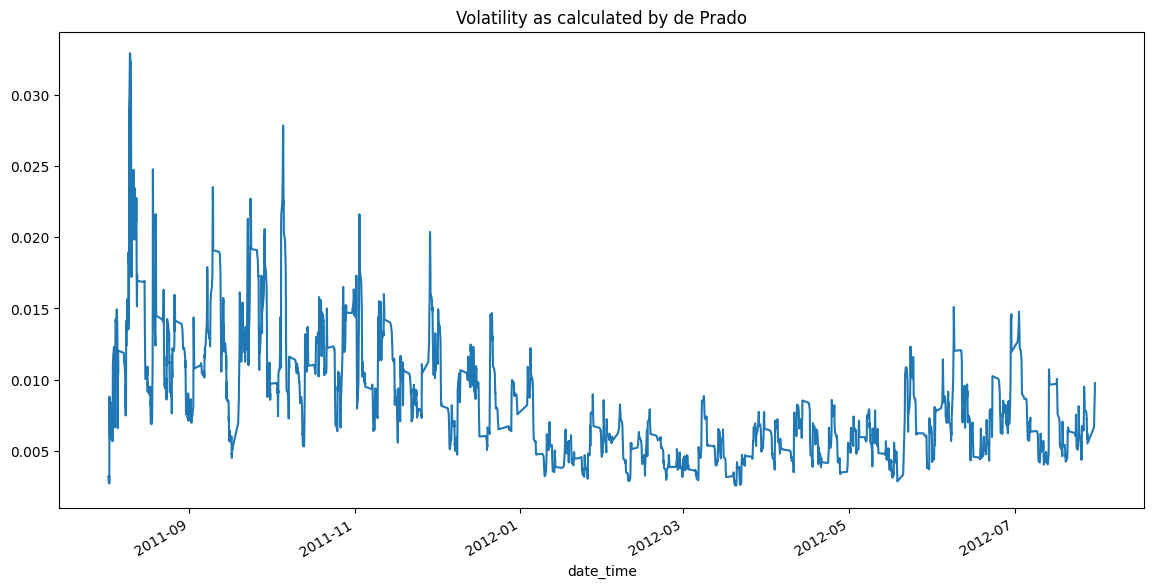

In [5]:
vol.plot(figsize=(14, 7), title='Volatility as calculated by de Prado')
plt.show()

In [6]:
# Apply Symmetric CUSUM filter and get timestamps for events
# Note: Only the CUSUM filter needs a point estimate for volatility
cusum_events = cusum_filter(data['close'], threshold=vol.mean())

**Use Snippet 3.4 on a pandas series t1, where numDays=1.**

In [7]:
# Compute vertical barrier
vertical_barriers = labeling.add_vertical_barrier(cusum_events, data['close'],num_days=1)
vertical_barriers.head()

2011-08-01 13:46:23.650   2011-08-02 13:50:40.053
2011-08-01 14:03:22.782   2011-08-02 14:04:29.869
2011-08-01 15:38:23.090   2011-08-02 15:49:00.114
2011-08-01 19:25:42.891   2011-08-02 19:26:07.927
2011-08-02 12:27:07.195   2011-08-03 13:07:43.154
Name: date_time, dtype: datetime64[ns]

**On those sampled features, apply the triple-barrier method, where ptSl=[1,1] and t1 is the series you created in point 1.b.**

In [8]:
triple_barrier_events = labeling.get_events(close=data['close'],
                                               t_events=cusum_events,
                                               pt_sl=[1, 1],
                                               target=vol,
                                               num_threads=1,
                                               vertical_barrier_times=vertical_barriers,
                                               side_prediction=None)

In [9]:
triple_barrier_events.head()

,t1,trgt,pt,sl
2011-08-02 12:27:07.195,2011-08-02 12:47:28.445,0.003266,1,1
2011-08-02 16:48:53.474,2011-08-02 19:52:57.011,0.007736,1,1
2011-08-02 19:42:30.586,2011-08-03 14:23:36.205,0.006815,1,1
2011-08-03 14:23:36.205,2011-08-03 14:37:04.871,0.006384,1,1
2011-08-03 15:13:42.802,2011-08-03 17:43:21.280,0.007114,1,1


In [10]:
labels = labeling.get_bins(triple_barrier_events, data['close'])

In [11]:
labels.head()

,ret,trgt,bin
2011-08-02 12:27:07.195,0.003550,0.003266,1
2011-08-02 16:48:53.474,-0.008510,0.007736,-1
2011-08-02 19:42:30.586,-0.009970,0.006815,-1
2011-08-03 14:23:36.205,-0.006647,0.006384,-1
2011-08-03 15:13:42.802,0.007641,0.007114,1


In [12]:
labels['bin'].value_counts()

bin
 1    292
-1    241
 0    130
Name: count, dtype: int64

---
#### 3.2 From exercise 1, use Snippet 3.8 to drop rare labels.

In [13]:
clean_labels = labeling.drop_labels(labels)

In [14]:
print(labels.shape)
print(clean_labels.shape)

(663, 3)
(663, 3)


---
#### 3.3 Adjust the getBins function (Snippet 3.5) to return a 0 whenever the vertical barrier is the one touched first.
This change was made inside the module CoreFunctions.

---
#### 3.4 Develop a trend-following strategy based on a popular technical analysis statistic (e.g., crossing moving averages). For each observation, themodel suggests a side, but not a size of the bet.

1. Derive meta-labels for pt_sl = [1,2] and t1 where num_days=1. Use as trgt the daily standard deviation as computed by Snippet 3.1.
2. Train a random forest to decide whether to trade or not. Note: The decision is whether to trade or not, {0,1}, since the underllying model (the crossing moveing average has decided the side{-1, 1})

In [15]:
# This question is answered in the notebook: Trend_Following_Strategy

----
#### 3.5 Develop a mean-reverting strategy based on Bollinger bands. For each observation, the model suggests a side, but not a size of the bet.

* (a) Derive meta-labels for ptSl = [0, 2] and t1 where numDays = 1. Use as trgt the daily standard deviation as computed by Snippet 3.1.
* (b) Train a random forest to decide whether to trade or not. Use as features: volatility, seial correlation, and teh crossinmg moving averages.
* (c) What is teh accuracy of prediction from the primary model? (i.e. if the secondary model does not filter the bets) What are the precision, recall and FI-scores?
* (d) What is teh accuracy of prediction from the primary model? What are the precision, recall and FI-scores?


In [16]:
# This question is answered in the notebook: Bollinger_Bands_Strategy

## References

- Advances in Financial Machine Learning, Chapter-03.